# LiH Molecule: Constructing Potential Energy Surfaces Using VQE

## Step 1: Classical calculations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utility import *
import tequila as tq
threshold = 1e-6 #Cutoff for UCC MP2 amplitudes and QCC ranking gradients

basis = 'sto-3g'

#### Classical Electronic Structure Methods

In [2]:
bond_lengths = np.linspace(0.7,3.0,15)
#Run FCI
FCI_PES = obtain_PES('lih', bond_lengths, basis, method='fci')
#Run HF
HF_PES = obtain_PES('lih', bond_lengths, basis,  method='hf')
#Run CCSD
CCSD_PES = obtain_PES('lih', bond_lengths, basis,  method='ccsd')

E = -7.505051767361807 Eh
E = -7.695307186216192 Eh
E = -7.797940480712805 Eh
E = -7.850886904225847 Eh
E = -7.875225404322417 Eh
E = -7.882644441701508 Eh
E = -7.879987227897543 Eh
E = -7.871519789475591 Eh
E = -7.860019217763555 Eh
E = -7.8473500000766085 Eh
E = -7.834797280603318 Eh
E = -7.823251672203907 Eh
E = -7.81328379544711 Eh
E = -7.805155556416904 Eh
E = -7.798843159455239 Eh
E = -7.4860204040661715 Eh
E = -7.677464259854675 Eh
E = -7.781036385083806 Eh
E = -7.8341635331748005 Eh
E = -7.8577487033244715 Eh
E = -7.863443533207834 Eh
E = -7.85807009427633 Eh
E = -7.845844464700195 Eh
E = -7.829457815381848 Eh
E = -7.810658539946649 Eh
E = -7.790604683358963 Eh
E = -7.770091643682429 Eh
E = -7.7496981251691475 Eh
E = -7.729870178602056 Eh
E = -7.710958961728265 Eh
E = -7.505041804061137 Eh
E = -7.695300845290883 Eh
E = -7.79793389680691 Eh
E = -7.85087954961508 Eh
E = -7.875216475211244 Eh
E = -7.882633296257904 Eh
E = -7.879973728010883 Eh
E = -7.871503905176357 Eh
E = -7.8600

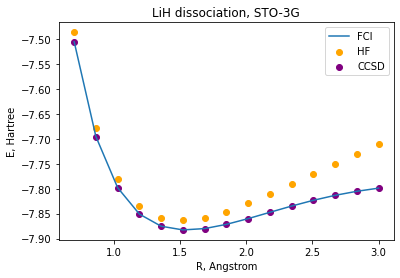

In [3]:
#Plot LiH PESs

plt.title('LiH dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend()

## Step 2: Generating Qubit Hamiltonians

In [4]:
qubit_transf = 'jw' # Jordan-Wigner transformations
lih = get_qubit_hamiltonian(mol='lih', geometry=1, basis='sto3g', qubit_transf=qubit_transf)
print(lih)

-3.9344419567578965 [] +
-0.007923321157850875 [X0 X1 Y2 Y3] +
-0.003414532358015549 [X0 X1 Y2 Z3 Z4 Y5] +
-0.0027468613203171523 [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Y11] +
-0.00341453235801555 [X0 X1 X3 X4] +
-0.0027468613203171523 [X0 X1 X3 Z4 Z5 Z6 Z7 Z8 Z9 X10] +
-0.004864778381760612 [X0 X1 Y4 Y5] +
-0.002296316587299247 [X0 X1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 Y11] +
-0.002296316587299247 [X0 X1 X5 Z6 Z7 Z8 Z9 X10] +
-0.0024727061683852756 [X0 X1 Y6 Y7] +
-0.0024727061683852765 [X0 X1 Y8 Y9] +
-0.0017744350099502088 [X0 X1 Y10 Y11] +
0.007923321157850875 [X0 Y1 Y2 X3] +
0.003414532358015549 [X0 Y1 Y2 Z3 Z4 X5] +
0.0027468613203171523 [X0 Y1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 X11] +
-0.00341453235801555 [X0 Y1 Y3 X4] +
-0.0027468613203171523 [X0 Y1 Y3 Z4 Z5 Z6 Z7 Z8 Z9 X10] +
0.004864778381760612 [X0 Y1 Y4 X5] +
0.002296316587299247 [X0 Y1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 X11] +
-0.002296316587299247 [X0 Y1 Y5 Z6 Z7 Z8 Z9 X10] +
0.0024727061683852756 [X0 Y1 Y6 X7] +
0.0024727061683852765 [X0 Y1 Y8 X9] +
0.00177

In [5]:
lih_tapered = taper_hamiltonian(lih, n_spin_orbitals=12, n_electrons=4, qubit_transf=qubit_transf)
print("Effective Hamiltonian:", lih_tapered)

## Tequila stuff

In [6]:
trotter_steps = 1

xyz_data = get_molecular_data('lih', geometry=1.5, xyz_format=True)
basis='sto-3g'

lih_tq = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set=basis)

print('Number of spin-orbitals (qubits): {} \n'.format(2*lih_tq.n_orbitals))

E_FCI = lih_tq.compute_energy(method='fci')

print('FCI energy: {}'.format(E_FCI))

Number of spin-orbitals (qubits): 12 

FCI energy: -7.882362286810973


In [ ]:
H = lih_tq.make_hamiltonian()

print("\nHamiltonian has {} terms\n".format(len(H)))

U_UCCSD = lih_tq.make_uccsd_ansatz(initial_amplitudes='MP2',threshold=threshold, trotter_steps=trotter_steps)

E = tq.ExpectationValue(H=H, U=U_UCCSD)

print('\nNumber of UCCSD amplitudes: {} \n'.format(len(E.extract_variables())))

print('\nStarting optimization:\n')

result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()}, tol=1e-6)

print('\nObtained UCCSD energy: {}'.format(result.energy))

In [ ]:
#Define number of entanglers to enter ansatz
n_ents = 1

#Rank entanglers using energy gradient criterion
ranked_entangler_groupings = generate_QCC_gradient_groupings(H.to_openfermion(), 
                                                             2*lih.n_orbitals, 
                                                             hf_reference, 
                                                             cutoff=threshold)

print('Grouping gradient magnitudes (Grouping : Gradient magnitude):')
for i in range(len(ranked_entangler_groupings)):
    print('{} : {}'.format(i+1,ranked_entangler_groupings[i][1]))


entanglers = get_QCC_entanglers(ranked_entangler_groupings, n_ents, 2*lih.n_orbitals)

print('\nSelected entanglers:')
for ent in entanglers:
    print(ent)

In [ ]:
H = tq.QubitHamiltonian.from_openfermion(get_qubit_hamiltonian('lih', 1.5, 'sto-3g', qubit_transf='jw'))

a = tq.Variable("tau_0")
U = construct_QMF_ansatz(8)
for ent in entanglers:
    U += tq.gates.ExpPauli(paulistring=tq.PauliString.from_string(ent), angle=a)
print(U)
